# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
!pip install -q scikit-plot
import scikitplot as skplt
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#for finding nonzero elements in sparse matrix
from scipy.sparse import find
#for f1_Score
from sklearn.metrics import f1_score
#for roc curve
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import coo_matrix, hstack
from scipy import interp
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
#for logistic regressor
from sklearn.linear_model import LogisticRegression
#for others
from tqdm import tqdm
import os
from google.colab import drive 
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# using SQLite Table to read data.
os.chdir("/content/drive/My Drive/Colab Notebooks") #changing directory
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 364171/364171 [03:23<00:00, 1793.11it/s]


In [23]:
preprocessed_reviews[1500]

'great ingredients although chicken rather chicken broth thing not think belongs canola oil canola rapeseed not someting dog would ever find nature find rapeseed nature eat would poison today food industries convinced masses canola oil safe even better oil olive virgin coconut facts though say otherwise late poisonous figured way fix still like could better'

<h3><font color='black'>[3.2] Splitting the data into test and train</font></h3>

In [24]:
final['Text'] = preprocessed_reviews
#clearing memory
preprocessed_reviews = []
#sampling 100k point for naive bayes. Also balancing the data
finalp = final[final.Score == 1].sample(50000,random_state =2)
finaln = final[final.Score == 0].sample(50000,random_state =2)
final = pd.concat([finalp,finaln],ignore_index=True)
final = final.sort_values('Time')
y = final.Score.values
X = final.Text.values
X_tr, X_test , y_tr, y_test = train_test_split(X,y,test_size=0.3)
print(final.Score.value_counts())
print(X_tr.shape,X_test.shape,y_tr.shape,y_test.shape)



1    50000
0    50000
Name: Score, dtype: int64
(70000,) (30000,) (70000,) (30000,)


# [4] Featurization

## [4.1] BAG OF WORDS

Skipping normal BoW. Going to bigrams BoW.

## [4.2] Bi-Grams BoW.

In [25]:
#BoW_bigrams
from sklearn.preprocessing import StandardScaler
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10) #in scikit-learn
bow_tr_vec = count_vect.fit_transform(X_tr)
bow_test_vec = count_vect.transform(X_test)
#standardising data
scaler = StandardScaler(with_mean=False) 
bow_tr_vec = scaler.fit_transform(bow_tr_vec)
bow_test_vec = scaler.transform(bow_test_vec)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)
print("the type of count vectorizer ",type(bow_tr_vec))
print("the shape of out text BOW vectorizer ",bow_tr_vec.get_shape())
print("the number of unique words ", bow_tr_vec.get_shape()[1])

some feature names  ['aa', 'aafco', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'abilities', 'ability', 'able', 'able buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (70000, 41548)
the number of unique words  41548


## [4.3] TF-IDF

In [26]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tfidf_tr_vec = tf_idf_vect.fit_transform(X_tr)
tfidf_test_vec = tf_idf_vect.transform(X_test)
scaler = StandardScaler(with_mean=False) 
tfidf_tr_vec = scaler.fit_transform(tfidf_tr_vec)
tfidf_test_vec = scaler.transform(tfidf_test_vec)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)
print("the type of count vectorizer ",type(tfidf_tr_vec))
print("the shape of out text TFIDF vectorizer ",tfidf_tr_vec.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_tr_vec.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abandoned', 'abc', 'abdominal', 'abdominal pain', 'abilities', 'ability', 'able', 'able buy']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70000, 41548)
the number of unique words including both unigrams and bigrams  41548


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in final['Text']:
    list_of_sentance.append(sentance.split())

In [28]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8515893220901489), ('fantastic', 0.8316882848739624), ('terrific', 0.8305378556251526), ('wonderful', 0.8234578967094421), ('excellent', 0.8183546662330627), ('good', 0.8144174218177795), ('perfect', 0.8108519315719604), ('amazing', 0.7732381820678711), ('fabulous', 0.7262856364250183), ('nice', 0.711384654045105)]
[('nastiest', 0.8234938383102417), ('weakest', 0.7196085453033447), ('greatest', 0.7154921889305115), ('foulest', 0.7096928954124451), ('best', 0.7073009014129639), ('vile', 0.6899132132530212), ('disgusting', 0.668196439743042), ('saltiest', 0.6643089652061462), ('horrid', 0.6355550289154053), ('terrible', 0.6295775175094604)]


In [29]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  19507
sample words  ['remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'preschoolers', 'turned', 'whole', 'school', 'purchasing', 'cd', 'along', 'children', 'tradition', 'lives', 'always', 'enjoyed', 'movie', 'funny', 'entertaining', 'not', 'hesitate', 'pick', 'edition', 'guess', 'marketing', 'plan', 'make', 'families', 'eliminated', 'strong', 'elements', 'usually', 'edited', 'version', 'warned']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [30]:
# average Word2Vec for training data
i=0
list_of_sent_intr=[]
for sent in X_tr:
    list_of_sent_intr.append(sent.split())

# compute average word2vec for each review.
sent_vectors_intr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_intr): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_intr.append(sent_vec)
print(len(sent_vectors_intr))
print(len(sent_vectors_intr[0]))

# average Word2Vec for test data
i=0
list_of_sent_intest=[]
for sent in X_test:
    list_of_sent_intest.append(sent.split())

# compute average word2vec for each review.
sent_vectors_intest = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_intest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_intest.append(sent_vec)
print(len(sent_vectors_intest))
print(len(sent_vectors_intest[0]))

100%|██████████| 70000/70000 [03:37<00:00, 322.10it/s]


70000
50


100%|██████████| 30000/30000 [01:35<00:00, 315.68it/s]

30000
50


In [0]:
#Performing Standardisation
scaler = StandardScaler() 
sent_vectors_intr = scaler.fit_transform(sent_vectors_intr)
sent_vectors_intest = scaler.transform(sent_vectors_intest)

#### [4.4.1.2] TFIDF weighted W2v

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_tr)
model.transform(X_test)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_intr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_intr): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_intr.append(sent_vec)
    row += 1
    
tfidf_sent_vectors_intest = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_intest): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_intest.append(sent_vec)
    row += 1
    
    


100%|██████████| 30000/30000 [14:05<00:00, 35.47it/s]


In [0]:
#Performing Standardisation
scaler = StandardScaler() 
tfidf_sent_vectors_intr = scaler.fit_transform(tfidf_sent_vectors_intr)
tfidf_sent_vectors_intest = scaler.transform(tfidf_sent_vectors_intest)

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.0.1 ]FUNCTIONS:


## # [5.0.1] Getting best hyperparamter.
*   Comparing AUC curves on both train and validation data.
*   Getting best value for C.
*   Here C = 1/ lambda
*   Then training the model with this hyperparameter C.








In [0]:
#Logistic regression classifier
def logis(Xtrain,ytrain,reg):
#Giving C parameters
  C_parameters = [{'C': [10**-4,10**-3,10**-2,10**-1, 10**0,10**1,10**2,10**3,10**4]}]
  C_values = [10**-4,10**-3,10**-2,10**-1, 10**0,10**1,10**2,10**3,10**4]
  
#Using GridSearchCV
  validation_score = []
  train_score = []
  model = GridSearchCV(LogisticRegression(penalty=reg), C_parameters, scoring = 'roc_auc',n_jobs=4, cv=2,return_train_score ='true')
  model.fit(Xtrain, ytrain)
#Train and test results are in model.cv_results_  
  regression = model.cv_results_
  validation_score = regression['mean_test_score']
  train_score = regression['mean_train_score']
# Changing c values to log for plotting  
  C_values_log = np.log(C_values)
  C_values_log.reshape(1,9)
#Get best estimator according to Gridsearchcv
  print(model.best_estimator_)
# Calculating best  c from train and test data by converting the array to list  
  validation_score = validation_score.tolist()
  train_score = train_score.tolist()
  optimal_c_cv = C_values[validation_score.index(max(validation_score))]
  optimal_c_tr = C_values[train_score.index(max(train_score))]
  log_tr = np.log(optimal_c_tr)
  log_cv = np.log(optimal_c_cv)
  optimal_c = float(np.exp((log_tr+log_cv)/2))
#plotting the curve  
  plt.figure()
  plt.title("AUC vs C")
  plt.plot(C_values_log,train_score,'b',label='Train AUC')
  plt.plot(C_values_log,validation_score,'darkorange',label='Validation AUC')
  plt.xlabel('C Value in natural log')
  plt.ylabel('Area Under ROC Curve')
  plt.gca().legend()
  plt.show()
  print('\nThe optimal c for training data is %f and ROC is %f.' % (optimal_c_tr,max(train_score)))
  print('\nThe optimal c for validation data is %f and ROC is %f.' % (optimal_c_cv,max(validation_score)))
  print('\nThe calculated optimal c for model is %f.' % optimal_c)
 
  return optimal_c


## #[5.0.2] Applying Logistic Regression with optimal c and Getting the ROC Curve.Also plotting the confusion matrix.

In [0]:
#Applying LR with optimal c
def lr_optimal(optimal_c,reg,Xtrain,Xtest):
  #for ROC Curve on train data
  clf = LogisticRegression(C=optimal_c, penalty=reg)
  clf.fit(Xtrain, y_tr)
  pred_train = clf.predict(Xtrain)
  #for ROC Curve on test data
  pred_test = clf.predict(Xtest)
  #Getting FPR AND TPR values for ROC Curve for train and test data
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr,tpr,_ = roc_curve(y_tr,pred_train)
  roc_auc_train = roc_auc_score(y_tr,pred_train)
  
  fpr2 = dict()
  tpr2 = dict()
  roc_auc2 = dict()
  fpr2,tpr2,_ = roc_curve(y_test,pred_test)
  roc_auc_test = roc_auc_score(y_test,pred_test)
  
  plt.figure()
  plt.title(" ROC Curve")
  plt.plot(fpr,tpr,'b',label='ROC curve for train data(area = %0.2f)' % roc_auc_train)
  plt.plot(fpr2,tpr2,'r',label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()
  
  print("Confusion Matrix for Train data")
  skplt.metrics.plot_confusion_matrix(y_tr,pred_train)
  print(classification_report(y_tr ,pred_train))
  print("="*50)
  print("Confusion matrix for Test data")
  skplt.metrics.plot_confusion_matrix(y_test,pred_test)
  print(classification_report(y_test ,pred_test))
  #for sparcity check
  w = clf.coef_
  
  return w  

  

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


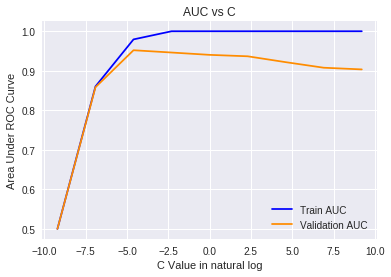


The optimal c for training data is 1000.000000 and ROC is 0.999997.

The optimal c for validation data is 0.010000 and ROC is 0.951950.

The calculated optimal c for model is 3.162278.


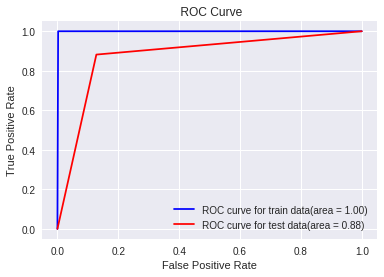

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35059
           1       1.00      1.00      1.00     34941

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     14941
           1       0.87      0.88      0.88     15059

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.88      0.88      0.88     30000
weighted avg       0.88      0.88      0.88     30000



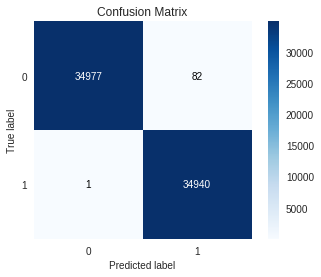

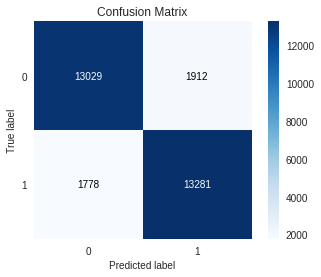

In [37]:
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(bow_tr_vec,y_tr,'l1')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l1',bow_tr_vec,bow_test_vec)


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [38]:
print(np.count_nonzero(w))

18709


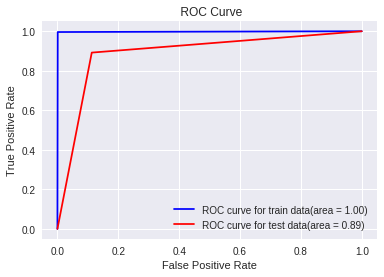

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35059
           1       1.00      1.00      1.00     34941

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     14941
           1       0.89      0.89      0.89     15059

   micro avg       0.89      0.89      0.89     30000
   macro avg       0.89      0.89      0.89     30000
weighted avg       0.89      0.89      0.89     30000



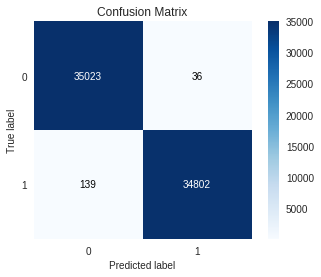

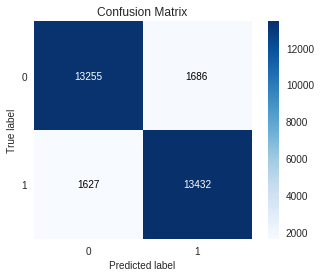

In [39]:
#performing LR again by decreasing c for same set .Take c = 0.1. Just for checking sparcity.
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(0.1,'l1',bow_tr_vec,bow_test_vec)

In [40]:
print(np.count_nonzero(w))

16067


Here, as c decreased from 1 to 0.1, that means lambda increased inversely, the sparcity of weight also increased.
Previously it was 18709.
Now, it is 16067.

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


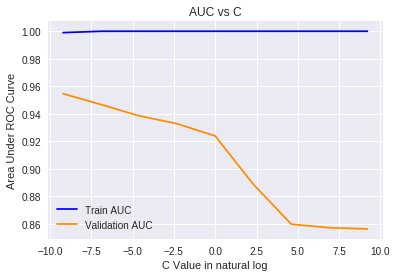


The optimal c for training data is 100.000000 and ROC is 0.999997.

The optimal c for validation data is 0.000100 and ROC is 0.954574.

The calculated optimal c for model is 0.100000.


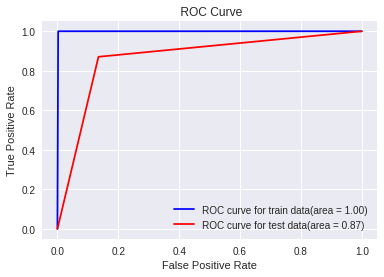

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35059
           1       1.00      1.00      1.00     34941

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14941
           1       0.87      0.87      0.87     15059

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.87      0.87      0.87     30000
weighted avg       0.87      0.87      0.87     30000



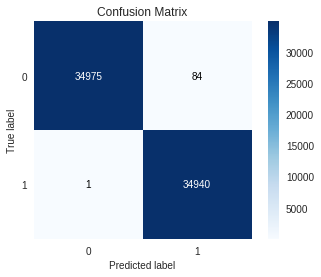

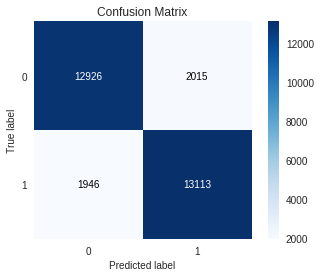

In [41]:
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(bow_tr_vec,y_tr,'l2')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l2',bow_tr_vec,bow_test_vec)


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

Perform Perturbation test to check the collinearity/multicollinearity of the features.
1. Get the non zero weights before adding noise using 'scipy.sparse.find'
2. Display the weights.
3. Add the noise . X.data+= e     (sparse matrix for BoW)
4. Perform LR and get the non-zero weights. 
5. Find the % change between W and W', percentage_change_vector = (| (W-W') / (W) |)*100)
6. Calculate percentile change and see if there is any sudden change.
7. Conclude.


In [42]:
#Perturbation test
w.shape #weight vector used in Bow with l2 reg.
#(I,J,V) : tuple of arrays.I,J, and V contain the row indices, column indices, and values of the nonzero matrix entries.
weight1 = find(w[0])[2] 
#Displaying the weights
print(weight1[0:50])


[ 0.01445295  0.00503304 -0.02754479 -0.02086435 -0.00501797 -0.0407803
  0.02166309  0.0400492   0.06708057  0.06862302 -0.0686388   0.02415886
 -0.00486234 -0.02785209  0.08021914 -0.04420391  0.00893579 -0.01026852
  0.09141507 -0.01255062  0.02064601  0.00719305  0.03987543  0.07231329
 -0.04889114  0.05061282 -0.05724404 -0.03104864 -0.01317167 -0.00125502
 -0.001543    0.02488959  0.00514249 -0.00852003 -0.03040163 -0.00988557
  0.0188576   0.00248072 -0.00721116  0.04760832  0.00365592  0.03864652
 -0.07051248  0.04543981  0.03895295 -0.01196586  0.04485751  0.11813996
 -0.04090402 -0.07475992]


In [43]:
#adding noise to bow
per_tr = bow_tr_vec
per_test = bow_test_vec
ep_tr = np.random.uniform(low=-0.0001,high = 0.0001,size=per_tr.size)
ep_test = np.random.uniform(low=-0.0001,high = 0.0001,size=per_test.size)
per_tr.data += ep_tr
per_test.data += ep_test
#standardising data
S = StandardScaler(with_mean=False)
per_tr = S.fit_transform(per_tr)
per_test = S.transform(per_test)
print(per_tr.shape,per_test.shape)



(70000, 41548) (30000, 41548)


LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


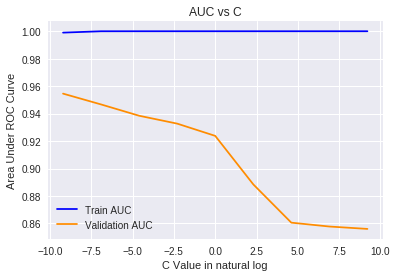


The optimal c for training data is 10.000000 and ROC is 0.999997.

The optimal c for validation data is 0.000100 and ROC is 0.954574.

The calculated optimal c for model is 0.031623.


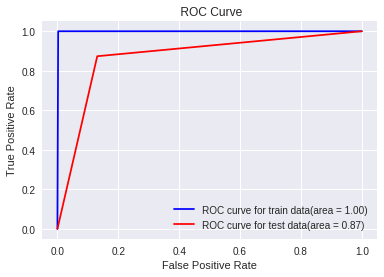

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35059
           1       1.00      1.00      1.00     34941

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14941
           1       0.87      0.87      0.87     15059

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.87      0.87      0.87     30000
weighted avg       0.87      0.87      0.87     30000



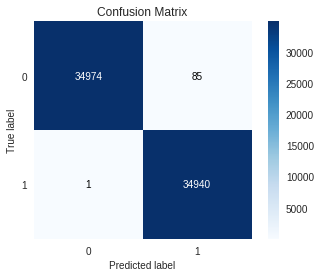

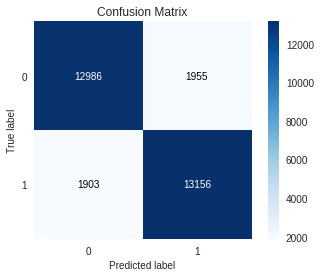

In [44]:
#perform LR
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(per_tr,y_tr,'l2')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w2 = lr_optimal(optimal_c,'l2',per_tr,per_test)


In [45]:
weight2 = find(w2[0])[2] 
print(weight2[:50])

[ 0.01290193  0.00082805 -0.02281439 -0.01717596 -0.00609853 -0.03143043
  0.01766159  0.03053342  0.05582043  0.05729248 -0.0542257   0.02021616
 -0.00527012 -0.02212185  0.06354466 -0.03716312  0.01003512 -0.00533376
  0.07514174 -0.00858287  0.01661809  0.00772287  0.03357428  0.05731684
 -0.0362705   0.04140832 -0.04758552 -0.02604627 -0.00999141 -0.0006207
 -0.00133228  0.01938032  0.00495568 -0.0073519  -0.02383733 -0.01032047
  0.01614196  0.00162575 -0.00662131  0.03916229  0.00473403  0.03172804
 -0.05777855  0.03183573  0.03236255 -0.01211499  0.03835915  0.08618241
 -0.03178566 -0.05942348]


In [0]:
w_change = (abs((weight1-weight2)/weight1) * 100)
mean_w_change = np.mean(w_change)

In [47]:
#Calculating percentiles of the data
ps = np.percentile(w_change,[10,20,30,40,50,60,70,90,100])
print(ps)

[1.08515805e+01 1.50816573e+01 1.73174104e+01 1.89191814e+01
 2.03562821e+01 2.19435564e+01 2.40217469e+01 3.84487486e+01
 1.18096310e+05]


In [64]:
#WE CAN SEE THERE IS DRASTIC CHANGE IN 90-100 PERCENTILE
ps = np.percentile(w_change,[91,92,93,94,95,96,97,98,99,100])
ps

array([4.10559724e+01, 4.47595634e+01, 4.92722813e+01, 5.52939651e+01,
       6.36191511e+01, 7.84064857e+01, 9.78023876e+01, 1.43635196e+02,
       2.97662739e+02, 1.18096310e+05])

In [66]:
ps = np.percentile(w_change,[99,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100])
ps

array([   297.66273854,    325.75149525,    373.34219421,    423.99827022,
          493.9300865 ,    601.90936083,    792.52784565,   1029.25438445,
         1483.0761781 ,   2360.3667696 , 118096.30983688])

There is sudden change in 99-100 percentile.

In [69]:
per_change_value = np.percentile(w_change,[99.9])
print("The proper value after which there is sudden rise in the values is %.2f " % per_change_value )

The proper value after which there is sudden rise in the values is 2360.37 


In [70]:
#Print the correlated features
per_change_value = int(per_change_value)
features_BoW = count_vect.get_feature_names()
p_features = pd.DataFrame(w_change,features_BoW)
print('The size of total multicollinearted features is ',(p_features[p_features[0]> (per_change_value)].size))
print(p_features[p_features[0]> (per_change_value)])




The size of total multicollinearted features is  42
                              0
ago still           2855.981934
assemble            9624.216836
best things         9819.420035
bought soup         3825.718470
box contained       2734.889911
breakfast snack    18390.622000
candy sweet         4377.709916
case boxes          9698.997203
channel             8627.876062
cup cocoa           9227.922338
definitely worst    4718.277044
depending much     34328.917299
emergency           9048.940301
flavor case         4224.195833
giving something    7059.629343
good could          3025.988561
good rice           2403.652314
good variety        3840.244742
great mild          8827.624214
hate wasting       40541.686096
keep purse          3365.976071
licks               2394.654002
love flavor        24070.798590
managers            8461.870643
months since      118096.309837
no quality          4863.286663
organic extra       7888.685427
pest                3903.990506
pet                 

In [71]:
print(p_features.size)

41548


Out of 41600 features, 417features are multicollinear. That counts to 0.1%.

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [53]:
# Getting feature names from BoW vectorizer
features_BoW = count_vect.get_feature_names()

#Merging them into a dataframe.
top_features = pd.DataFrame(w,columns = features_BoW)
top_features = top_features.T
pos = top_features[top_features[0] > 0]
neg = top_features[top_features[0] < 0]
print(pos[0].sort_values(ascending=False)[0:10])


great        0.729016
best         0.556179
love         0.545468
good         0.456917
perfect      0.428195
excellent    0.425870
loves        0.416283
delicious    0.415916
happy        0.382493
tasty        0.349738
Name: 0, dtype: float64


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [54]:
print(neg[0].sort_values(ascending=False)[0:10])

hate wasting      -0.000005
put anything      -0.000009
smell product     -0.000010
managers          -0.000011
breakfast snack   -0.000012
rican             -0.000018
pour contents     -0.000020
organic extra     -0.000021
cup cocoa         -0.000025
assemble          -0.000026
Name: 0, dtype: float64


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


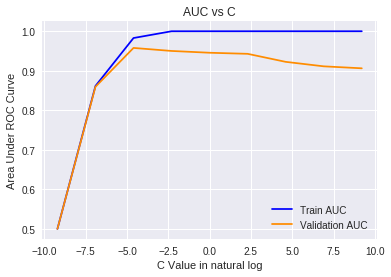


The optimal c for training data is 1000.000000 and ROC is 0.999997.

The optimal c for validation data is 0.010000 and ROC is 0.957795.

The calculated optimal c for model is 3.162278.


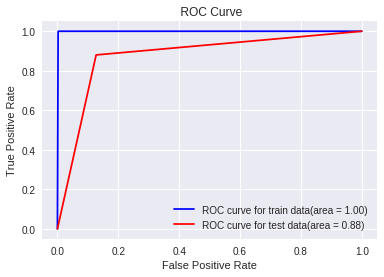

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35059
           1       1.00      1.00      1.00     34941

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.88      0.87      0.88     14941
           1       0.87      0.88      0.88     15059

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.88      0.88      0.88     30000
weighted avg       0.88      0.88      0.88     30000



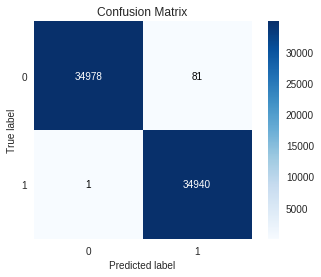

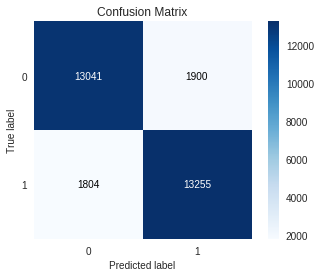

In [55]:
#perform LR
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(tfidf_tr_vec,y_tr,'l1')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l1',tfidf_tr_vec,tfidf_test_vec)

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)


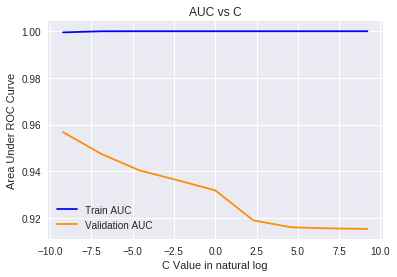


The optimal c for training data is 1.000000 and ROC is 0.999997.

The optimal c for validation data is 0.000100 and ROC is 0.956775.

The calculated optimal c for model is 0.010000.


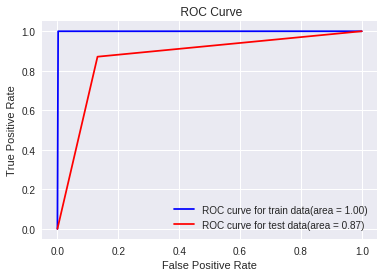

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35059
           1       1.00      1.00      1.00     34941

   micro avg       1.00      1.00      1.00     70000
   macro avg       1.00      1.00      1.00     70000
weighted avg       1.00      1.00      1.00     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     14941
           1       0.87      0.87      0.87     15059

   micro avg       0.87      0.87      0.87     30000
   macro avg       0.87      0.87      0.87     30000
weighted avg       0.87      0.87      0.87     30000



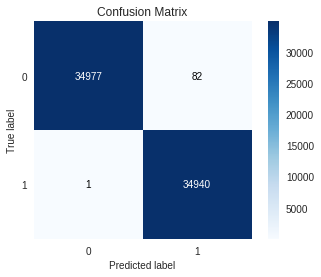

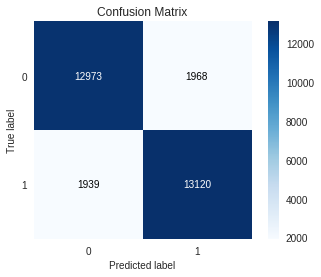

In [56]:
#perform LR
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(tfidf_tr_vec,y_tr,'l2')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l2',tfidf_tr_vec,tfidf_test_vec)

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [57]:
# Getting feature names from BoW vectorizer
features_tfidf = tf_idf_vect.get_feature_names()

#Merging them into a dataframe.
top_features = pd.DataFrame(w,columns = features_tfidf)
top_features = top_features.T
pos = top_features[top_features[0] > 0]
neg = top_features[top_features[0] < 0]
print(pos[0].sort_values(ascending=False)[0:10])

great        0.389956
best         0.302354
love         0.272877
good         0.248603
perfect      0.237747
delicious    0.235001
loves        0.219127
excellent    0.199834
happy        0.191699
tasty        0.172057
Name: 0, dtype: float64


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [58]:
print(neg[0].sort_values(ascending=False)[0:10])

no big            -2.359340e-07
carnitine         -3.909623e-06
bear naked        -4.478973e-06
added chocolate   -5.939753e-06
tried drink       -6.515344e-06
besides           -7.024718e-06
rican             -9.579017e-06
anyone eat        -9.794870e-06
coffee sugar      -1.056470e-05
sorry not         -1.087127e-05
Name: 0, dtype: float64


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


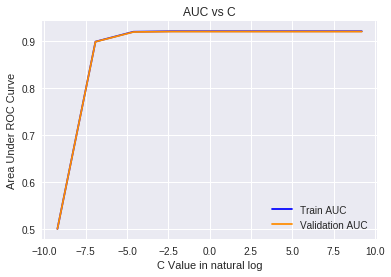


The optimal c for training data is 1000.000000 and ROC is 0.921679.

The optimal c for validation data is 0.100000 and ROC is 0.920958.

The calculated optimal c for model is 10.000000.


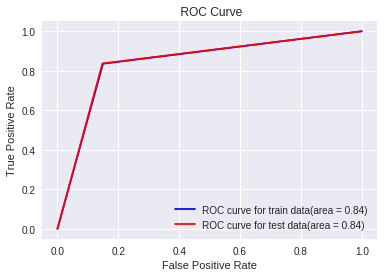

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     35059
           1       0.85      0.84      0.84     34941

   micro avg       0.84      0.84      0.84     70000
   macro avg       0.84      0.84      0.84     70000
weighted avg       0.84      0.84      0.84     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     14941
           1       0.85      0.84      0.84     15059

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.84      0.84      0.84     30000
weighted avg       0.84      0.84      0.84     30000



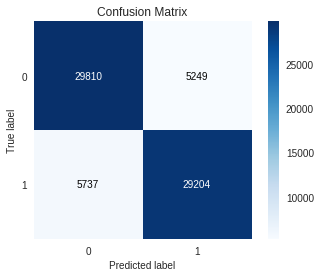

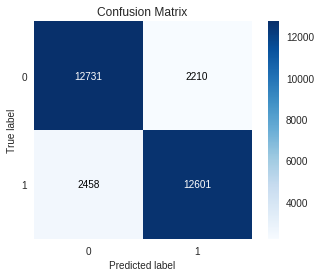

In [59]:
#perform LR
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(sent_vectors_intr,y_tr,'l1')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l1',sent_vectors_intr,sent_vectors_intest)

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


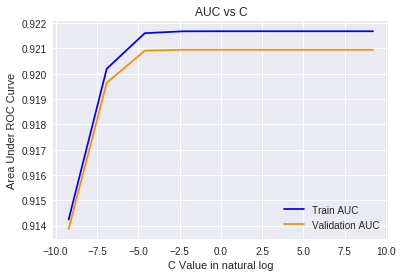


The optimal c for training data is 10.000000 and ROC is 0.921679.

The optimal c for validation data is 0.100000 and ROC is 0.920948.

The calculated optimal c for model is 1.000000.


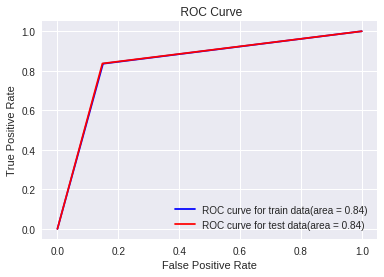

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.84      0.85      0.84     35059
           1       0.85      0.84      0.84     34941

   micro avg       0.84      0.84      0.84     70000
   macro avg       0.84      0.84      0.84     70000
weighted avg       0.84      0.84      0.84     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.84      0.85      0.85     14941
           1       0.85      0.84      0.84     15059

   micro avg       0.84      0.84      0.84     30000
   macro avg       0.84      0.84      0.84     30000
weighted avg       0.84      0.84      0.84     30000



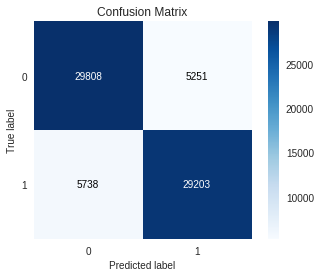

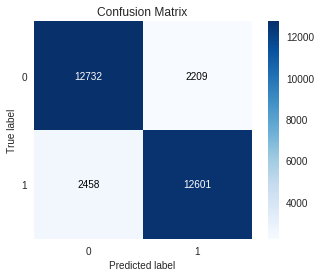

In [60]:
#perform LR
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(sent_vectors_intr,y_tr,'l2')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l2',sent_vectors_intr,sent_vectors_intest)

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


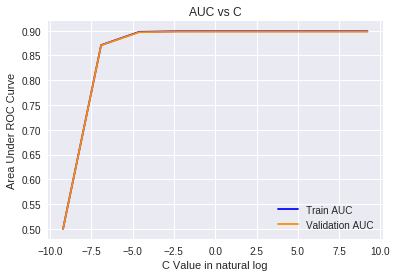


The optimal c for training data is 1000.000000 and ROC is 0.898950.

The optimal c for validation data is 0.100000 and ROC is 0.898147.

The calculated optimal c for model is 10.000000.


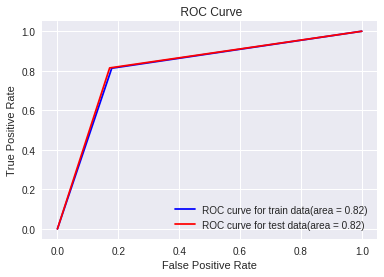

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     35059
           1       0.82      0.81      0.82     34941

   micro avg       0.82      0.82      0.82     70000
   macro avg       0.82      0.82      0.82     70000
weighted avg       0.82      0.82      0.82     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     14941
           1       0.83      0.81      0.82     15059

   micro avg       0.82      0.82      0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000



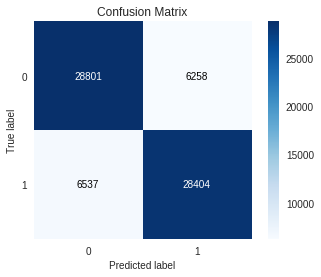

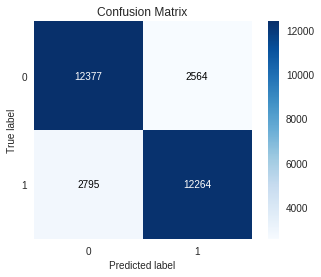

In [61]:
#perform LR
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(tfidf_sent_vectors_intr,y_tr,'l1')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l1',tfidf_sent_vectors_intr,tfidf_sent_vectors_intest)

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


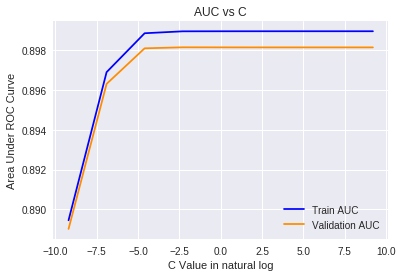


The optimal c for training data is 100.000000 and ROC is 0.898950.

The optimal c for validation data is 0.100000 and ROC is 0.898143.

The calculated optimal c for model is 3.162278.


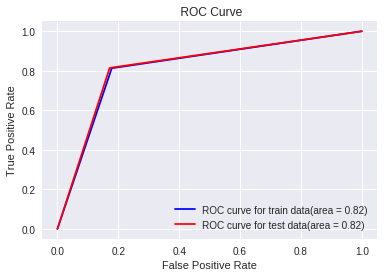

Confusion Matrix for Train data
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     35059
           1       0.82      0.81      0.82     34941

   micro avg       0.82      0.82      0.82     70000
   macro avg       0.82      0.82      0.82     70000
weighted avg       0.82      0.82      0.82     70000

Confusion matrix for Test data
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     14941
           1       0.83      0.81      0.82     15059

   micro avg       0.82      0.82      0.82     30000
   macro avg       0.82      0.82      0.82     30000
weighted avg       0.82      0.82      0.82     30000



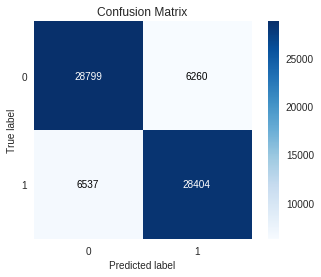

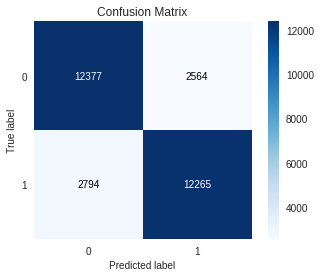

In [62]:
#perform LR
#Calulating optimal c by comparing auc of train and cv data
optimal_c = logis(tfidf_sent_vectors_intr,y_tr,'l2')
#applying LR using optimal c and plotting ROC curve and confusion matrix
w = lr_optimal(optimal_c,'l2',tfidf_sent_vectors_intr,tfidf_sent_vectors_intest)

# [6] Conclusions

In [72]:
!pip install -q PTable
from prettytable import PrettyTable
z = PrettyTable()
z.field_names = ["Vectorizer", "Model", "Regularisation","Hyperparameter c = 1/λ", "AUC"]
#Final summary
z.add_row(["BoW", 'Logistic Regression','l1',3.162278, '0.88'])
z.add_row(["BoW", 'Logistic Regression', 'l2',0.01, '0.87'])
z.add_row(["TF_IDF",'Logistic Regression','l1', 3.162278, '0.88'])
z.add_row(["TF_IDF", 'Logistic Regression','l2', 0.01, '0.87'])
z.add_row(["Avg W2V", 'Logistic Regression','l1', 10, '0.84'])
z.add_row(["Avg W2V", 'Logistic Regression', 'l2',1, '0.84'])
z.add_row(["TF_IDF weighted W2V",'Logistic Regression','l1', 10, '0.82'])
z.add_row(["TF_IDF weighted W2V", 'Logistic Regression','l2', 1, '0.82'])
print(z)

+---------------------+---------------------+----------------+------------------------+------+
|      Vectorizer     |        Model        | Regularisation | Hyperparameter c = 1/λ | AUC  |
+---------------------+---------------------+----------------+------------------------+------+
|         BoW         | Logistic Regression |       l1       |        3.162278        | 0.88 |
|         BoW         | Logistic Regression |       l2       |          0.01          | 0.87 |
|        TF_IDF       | Logistic Regression |       l1       |        3.162278        | 0.88 |
|        TF_IDF       | Logistic Regression |       l2       |          0.01          | 0.87 |
|       Avg W2V       | Logistic Regression |       l1       |           10           | 0.84 |
|       Avg W2V       | Logistic Regression |       l2       |           1            | 0.84 |
| TF_IDF weighted W2V | Logistic Regression |       l1       |           10           | 0.82 |
| TF_IDF weighted W2V | Logistic Regression |     

1. Used GridSearch.It has inbuilt function for train and test score.
2. As c decreases, lambda increases, observed that sparcity of a matrix increases.
3. Did perturbation test. Observed that it is not a much robust test since, only 1% features were counted as multicollinear. Can increase the threshold, but the restraint is that it is a manual test.